# Load - Wrangle - EDA

In [1]:
import os
import sys
import pandas as pd
import numpy as np


from wordcloud import WordCloud
from pandas_profiling import ProfileReport

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as plty

import missingno as msno

# Textacy

import spacy
from spacy.matcher import Matcher
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

#https://realpython.com/natural-language-processing-spacy-python/
matcher = Matcher(nlp.vocab)

join_comments = True
join_raw_article = True

# Set Project Root
PROJ_ROOT = os.path.join(os.pardir)
print(os.path.abspath(PROJ_ROOT))

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(PROJ_ROOT, "src")
sys.path.append(src_dir)


# %run "$BASE_DIR/settings.py"


%config InlineBackend.figure_format = 'png'

# Set to Reload all custom packages
%load_ext autoreload
%autoreload 2

%matplotlib inline

# !python -m spacy download en_core_web_sm

from collections import Counter


g:\My Drive\Code\springboard_proj_nlp_nytimes


## Load All Article Comments

In [2]:
df_comments = pd.read_csv('..//data//raw//nyt-comments-2020.csv',parse_dates=['createDate','updateDate','approveDate'])
df_comments.sort_values(by='createDate',inplace=True,ascending=True)

## Full Article Verbose / Write to file
df_comments.to_csv('..//data//processed//df_comments.csv')
df_comments.to_pickle('..//data//processed//df_comments.pkl')

## Sample Article Verbose / Write to file
df_sample = df_comments.sample(frac=0.05)
df_sample.to_csv('..//data//processed//df_comments_sample.csv')
df_sample.to_pickle('..//data//processed//df_comments_sample.pkl')

## Load NYT Articles
Will join with a more verbose set of data
(This is the whole list (not train and test split)

In [ ]:
# # All Articles
# df_articles = pd.read_csv('..//data//raw//nyt-articles-2020.csv',parse_dates=['pub_date'])
# df_articles.sort_values(by='pub_date',inplace=True,ascending=True)

## Load Enhanced Articles

Pull print section, print_page, lead_paragraph, and headlines to provide possible more text features that are not present in original dataset

In [ ]:
# build file list matching the pickle file name pattern
filelist = ['..//data//raw//2020-'+ str(x).zfill(2) + '-articles.pickle' for x in range(1,13)]

df_articles_verbose = pd.DataFrame()
df_temp = pd.DataFrame()

# For each one of the file names
for filename in filelist[0:13]:
    print('Filename: ' + filename)
    
    # Get large articles file
    df_json = pd.read_pickle(filename)
    df_json = df_json[['uri','print_section','print_page','lead_paragraph','headline.main','byline.person','byline.organization','headline.sub']]
    
    df_temp = df_temp.append(df_json,ignore_index=True)
 
  
    del(df_json)


Filename: ..//data//raw//2020-01-articles.pickle
Filename: ..//data//raw//2020-02-articles.pickle
Filename: ..//data//raw//2020-03-articles.pickle
Filename: ..//data//raw//2020-04-articles.pickle
Filename: ..//data//raw//2020-05-articles.pickle
Filename: ..//data//raw//2020-06-articles.pickle
Filename: ..//data//raw//2020-07-articles.pickle
Filename: ..//data//raw//2020-08-articles.pickle
Filename: ..//data//raw//2020-09-articles.pickle
Filename: ..//data//raw//2020-10-articles.pickle
Filename: ..//data//raw//2020-11-articles.pickle
Filename: ..//data//raw//2020-12-articles.pickle


## Join enhanced article data to original article df

In [ ]:
# Merge Articles Back
df_articles_verbose = pd.merge(df_articles,df_temp, how='left', left_on='uniqueID',right_on='uri',suffixes=['_left','_right'])

In [ ]:
## Full Article Verbose / Write to file
df_articles_verbose.to_csv('..//data//processed//df_articles.csv')
df_articles_verbose.to_pickle('..//data//processed//df_articles.pkl')

## Sample Article Verbose / Write to file
df_sample = df_articles_verbose.sample(frac=0.05)
df_sample.to_csv('..//data//processed//df_articles_sample.csv')
df_sample.to_pickle('..//data//processed//df_articles_sample.pkl')


# Data Wrangling

### Load Sample or Full Set of Articles

In [2]:
# Flag to set whether we are loading sample or full article set
load_sample = False

if load_sample:
    # Load Sample Data
    EDA_note = '_sample'
    df_articles = pd.read_pickle('..//data//processed//df_articles_sample.pkl')

if not load_sample:
    # Load Real Data
    EDA_note = '_full'
    df_articles = pd.read_pickle('..//data//processed//df_articles.pkl')

# # Drop constant columns, userTitle is 99% empty
# df_comments.drop(columns=['status','trusted','recommendedFlag','isAnonymous','userTitle'],inplace=True)

# Convert Timestamps where necessary
df_articles['pub_date'] = pd.to_datetime(df_articles['pub_date'])
# df_comments['createDate'] = pd.to_datetime(df_comments['createDate'])
# df_comments['updateDate'] = pd.to_datetime(df_comments['updateDate'])
# df_comments['approveDate'] = pd.to_datetime(df_comments['approveDate'])

# Drop constant columns, userTitle is 99% empty
df_articles.drop(columns=['uri','byline.person'],inplace=True)

# NAN Drops
# Drop Keyword Columns that are not str
df_articles.dropna(subset=['keywords'],inplace=True) # Key for teh NER to work

## Feature Engineering

### Simple Features

#### Add Month and drop unused columns

In [3]:
# Features
df_articles['month'] = df_articles['pub_date'].dt.month
df_articles = df_articles.drop(columns=['byline.organization','subsection','headline.sub'])

In [4]:
df_articles.describe().T

,count,mean,std,min,25%,50%,75%,max
word_count,16786.0,1300.961813,944.801861,0.0,874.0,1183.0,1502.0,15619.0
n_comments,16786.0,297.056714,513.419176,1.0,21.0,87.0,323.0,8987.0
month,16786.0,6.320743,3.437056,1.0,3.0,6.0,9.0,12.0


## Complex Text Features

Use custom nlp_tools module that I wrote to simplify

headline, abstract, lead_paragraph are text features

Binary 

- No comment
- Logistic Regression (0 vs num)
- XGBoost / Light
  - ROC Curve 
  - Confusion Metrix based
  - Lift
- Low Comment
- Comment zeroed out, binary

Ideas
- How many sentences in lead paragraph - list(doc.sents)
- How many Entities, Org, People, etc - doc.<something> or doc.ents
- How many Nouns, Verbs, Etc.
- Average lengths of the words with token

Features
- Add rules based on city occurences...ie NY is New York, etc.  
  - Require a word count analysis to find this out
  - Example: nlp.get_pipe("attribute_ruler").add([[{"TEXT": "NY"}]], {"LEMMA": "New York"})
  
spacy Investigate
  - 

### Spacy NER
for ent in piano_class_doc.ents:
...     print(ent.text, ent.start_char, ent.end_char,
...           ent.label_, spacy.explain(ent.label_))

In [7]:
# Get part of speech 
def get_pos_tag_len(text, pos_type):
    doc = nlp(text)
    pos = []
    for token in doc:
        if token.pos_ == pos_type:
            pos.append(token.pos_)
    pos = Counter(pos)
    return (pos[pos_type])


#'PROPN', 'PUNCT', 'DET', 'NOUN', 'VERB', 'ADV', 'SCONJ', 'PRON', 'ADP', 'ADJ', 'AUX', 'NUM', 'INTJ#'

In [8]:
# # Get Entities
def get_ent_tag_len(text,ent_label):
    ents = []
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ == ent_label:
            ents.append(ent.text)

    ents = Counter(ents)
    return (len(ents))

# 'PERSON'
# 'NORP' - Nationalities, relgious, political groups
# 'FAC' - Buildings, airports, highways, bridges, etc
# 'ORG' - Companies, Agencies, Institutions
# 'GPE' - Countries, Cities, States
# 'PRODUCT' - Objects, vehicles, foods, etc



### Make POS Features
Count parts of speech by type (POS)

In [9]:
# Add spacy Nouns
df_articles['TEXT_Keywords_POS_NOUN'] = df_articles['keywords'].apply(get_pos_tag_len,pos_type='NOUN')

In [10]:
# Add PropN
df_articles['TEXT_Keywords_POS_PNOUN'] = df_articles['keywords'].apply(get_pos_tag_len,pos_type='PROPN')

### Make Ent Labels

In [11]:
# Add Spacy Entities of Organizations
df_articles['TEXT_Keywords_ENT_ORG'] = df_articles['keywords'].apply(get_ent_tag_len,ent_label='ORG')

In [12]:
# Add Spacy Entities of Nationalities, Religious, Political Group
df_articles['TEXT_Keywords_ENT_NORP'] = df_articles['keywords'].apply(get_ent_tag_len,ent_label='NORP')

In [13]:
# Add Spacy Entities Buildings, Airports, Highways
df_articles['TEXT_Keywords_ENT_FAC'] = df_articles['keywords'].apply(get_ent_tag_len,ent_label='FAC')


In [14]:
# Add Spacy Entities Countries, Cities, States
df_articles['TEXT_Keywords_ENT_GPE'] = df_articles['keywords'].apply(get_ent_tag_len,ent_label='GPE')

In [15]:
# Add spacy entities Locations
df_articles['TEXT_Keywords_ENT_LOC'] = df_articles['keywords'].apply(get_ent_tag_len,ent_label='LOC')

In [16]:
# Add spacy entities locations People
df_articles['TEXT_Keywords_ENT_PERSON'] = df_articles['keywords'].apply(get_ent_tag_len,ent_label='PERSON')

### Comment Split to Binary Column

In [17]:
comment_split = 350
cut_labels = [0,1]
cut_bins = [0,comment_split,max(df_articles['n_comments'])]

# Process Square Footage
# Enable Hue of building size
df_articles['comment_isHigh'] = pd.cut(df_articles['n_comments'], bins=cut_bins, labels=cut_labels)
df_articles.head(1).T

,newsdesk,section,material,headline,abstract,keywords,word_count,pub_date,n_comments,uniqueID,...,month,TEXT_Keywords_POS_NOUN,TEXT_Keywords_POS_PNOUN,TEXT_Keywords_ENT_ORG,TEXT_Keywords_ENT_NORP,TEXT_Keywords_ENT_FAC,TEXT_Keywords_ENT_GPE,TEXT_Keywords_ENT_LOC,TEXT_Keywords_ENT_PERSON,comment_isHigh
0,Editorial,Opinion,Editorial,Protect Veterans From Fraud,Congress could do much more to protect America...,"['Veterans', 'For-Profit Schools', 'Financial ...",680,2020-01-01 00:18:54+00:00,186,nyt://article/69a7090b-9f36-569e-b5ab-b0ba5bb3...,...,1,4,16,4,0,0,0,0,0,0
1,Games,Crosswords & Games,News,‘It’s Green and Slimy’,Christina Iverson and Jeff Chen ring in the Ne...,['Crossword Puzzles'],931,2020-01-01 03:00:10+00:00,257,nyt://article/9edddb54-0aa3-5835-a833-d311a76f...,...,1,0,2,0,0,0,0,0,0,0
2,Science,Science,News,Meteor Showers in 2020 That Will Light Up Nigh...,"All year long, Earth passes through streams of...","['Meteors and Meteorites', 'Space and Astronom...",1057,2020-01-01 05:00:08+00:00,6,nyt://article/04bc90f0-b20b-511c-b5bb-3ce13194...,...,1,2,5,1,0,0,0,1,0,0
3,Science,Science,Interactive Feature,Sync your calendar with the solar system,"Never miss an eclipse, a meteor shower, a rock...","['Space and Astronomy', 'Moon', 'Eclipses', 'S...",0,2020-01-01 05:00:12+00:00,2,nyt://interactive/5b58d876-9351-50af-9b41-a312...,...,1,5,5,2,0,0,0,0,1,0
4,Science,Science,News,"Rocket Launches, Trips to Mars and More 2020 S...",A year full of highs and lows in space just en...,"['Space and Astronomy', 'Private Spaceflight',...",1156,2020-01-01 05:02:38+00:00,25,nyt://article/bd8647b3-8ec6-50aa-95cf-2b81ed12...,...,1,5,57,5,1,0,6,1,5,0


In [22]:
df_articles.sort_values(by='n_comments',ascending=False,inplace=True)

## Write Engineered Features back to File

In [35]:
## Full Article Verbose / Write to file
df_articles.to_csv('..//data//processed//df_articles_fe.csv')
df_articles.to_pickle('..//data//processed//df_articles_fe.pkl')

### Reload

In [36]:
## Load exit from EDA
df_articles = pd.read_pickle('..//data//processed//df_articles_fe.pkl')

# EDA

In [40]:
df_articles = pd.read_pickle('..//data//processed//df_articles_fe.pkl')

### Drop poorly correlated columns -
df_articles = df_articles.drop(columns=(df_articles.filter(like='LeadParagraph',axis=1).columns))
df_articles = df_articles.drop(columns=(df_articles.filter(like='headline',axis=1).columns))


In [41]:
df_articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16786 entries, 12618 to 9214
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   newsdesk                  16786 non-null  object             
 1   section                   16786 non-null  object             
 2   material                  16786 non-null  object             
 3   abstract                  16783 non-null  object             
 4   keywords                  16786 non-null  object             
 5   word_count                16786 non-null  int64              
 6   pub_date                  16786 non-null  datetime64[ns, UTC]
 7   n_comments                16786 non-null  int64              
 8   uniqueID                  16786 non-null  object             
 9   print_section             11597 non-null  object             
 10  print_page                11597 non-null  object             
 11  lead_paragra

### Generate Pandas Profiles for EDA
Create generic EDA, drill down where necesary

EDA Ideas
- Ratio of has n_comments to no n_comments
- Missing data
- Top Words
- Top POS Speech
- Correlations
- Wordcloud
- Comments by Month
- Correlations

In [27]:
profile_articles = ProfileReport(df_articles, title="New York Times - Articles " + EDA_note)
profile_articles.to_file('..//reports//figures//EDA_Articles' + EDA_note + '.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 13.73it/s]


### Examine Missing Data

<AxesSubplot:>

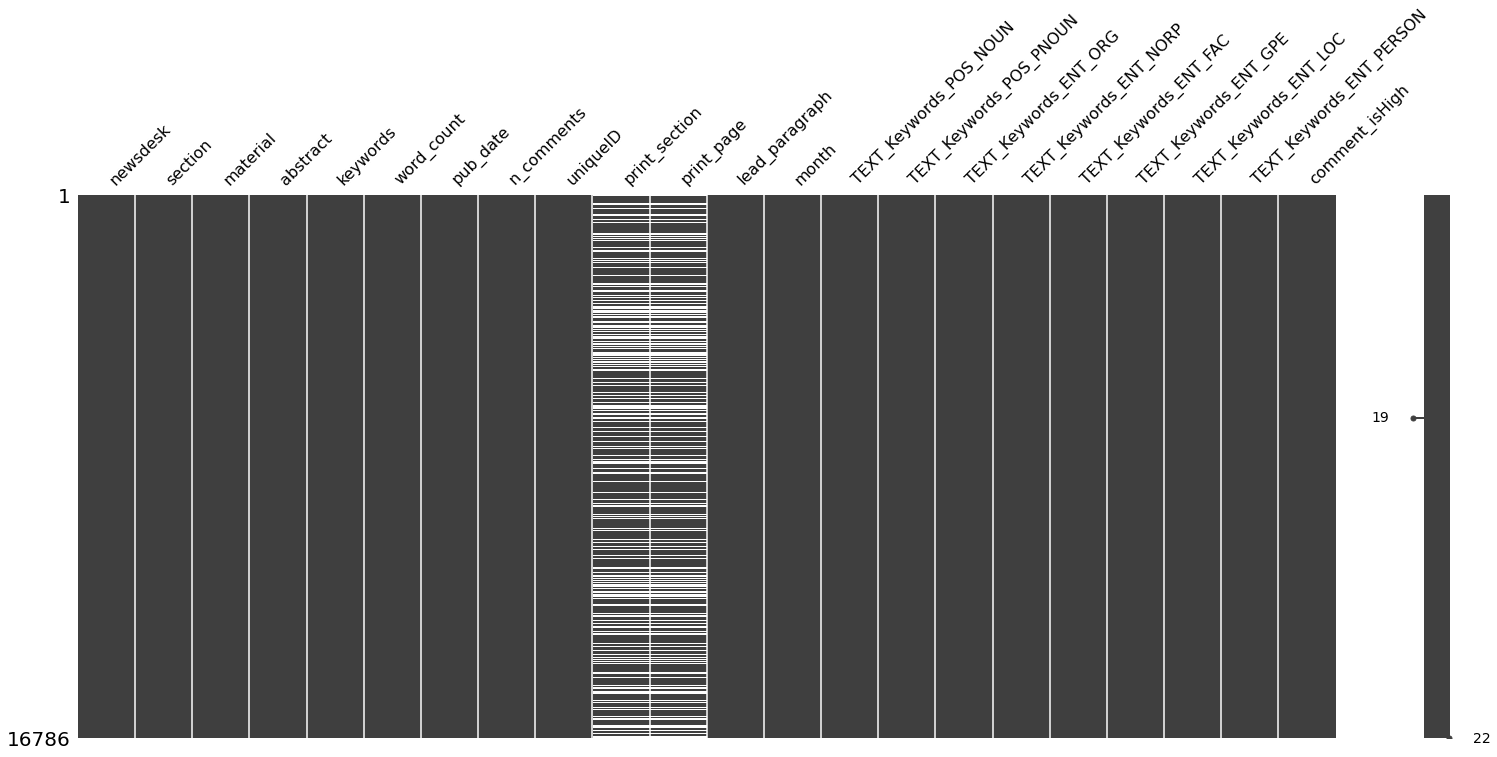

In [28]:
msno.matrix(df_articles)

## Pivots

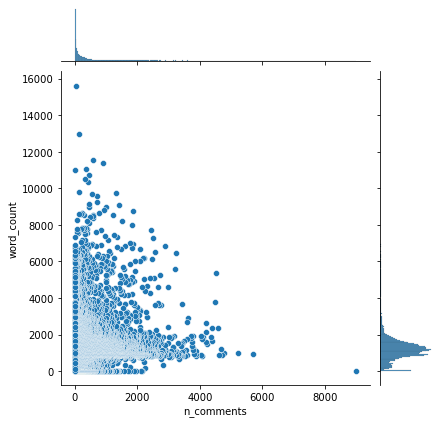

In [29]:
plt.rcParams['figure.figsize']=60,15
sns.jointplot(data=df_articles,x='n_comments',y='word_count')

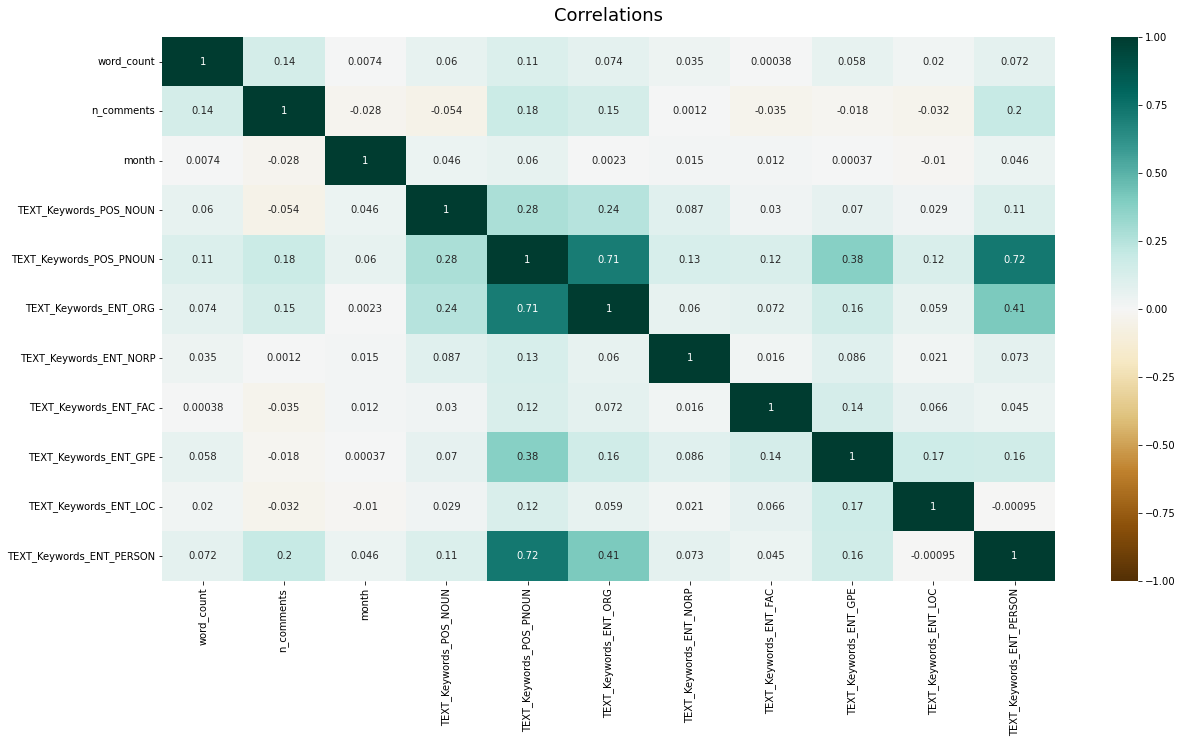

In [42]:
plt.ioff()
plt.figure(figsize=(20, 10))

heatmap = sns.heatmap(df_articles.corr(),vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlations', fontdict={'fontsize':18}, pad=16);


The strongest correlations (still pretty weak) is the keywords and whether the article speaks of a person (TEXT_Keywords_ENT_PERSON)


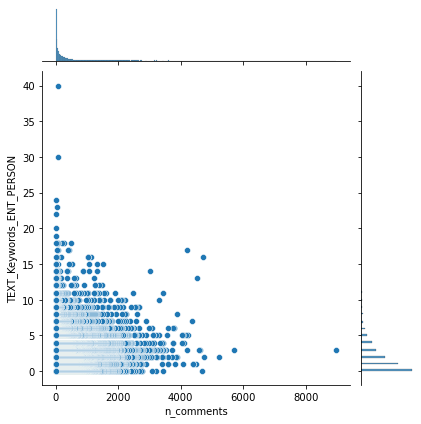

In [43]:
plt.rcParams['figure.figsize']=60,15
sns.jointplot(data=df_articles,x='n_comments',y='TEXT_Keywords_ENT_PERSON')

In [44]:
df_articles.head(1).T

,12618
newsdesk,U.S.
section,U.S.
material,Interactive Feature
abstract,The Times obtained Donald Trump’s tax informat...
keywords,"['Trump, Donald J', 'Trump Tax Returns', 'Conf..."
word_count,0
pub_date,2020-09-27 21:07:33+00:00
n_comments,8987
uniqueID,nyt://interactive/a36f9b6d-eea3-5c5c-be2d-ee90...
print_section,A
